# Servo simulation draft

Outline for simulating response from two-level ion when driven with a drifting clock laser. Linewidth functions interchangeable.

TODO:
- integrate dead time ($e^{-(t_{meas}/\tau_{ion})}$)
- laser noise & linewidth
- some way to simulate different measurement cycles (LHHL), maybe add an impact on dead time due to servo re-alignment?

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks
from scipy.stats import cauchy, binom
import allantools

Lineshape function used is the ideal Rabi flopping when driven with pi pulses:
\begin{align}
\rho_{ee}(t) = \left( \frac{\pi}{2} \right)^2 \textrm{sinc}^2 \left( \frac{\sqrt{\pi^2 + \delta^2 t^2}}{2} \right)
\end{align} 

In [9]:
def lineshape(delta, t, state_prep=False):
    sinc_arg = 0.5 * np.sqrt(np.pi ** 2 + np.square(delta * (2 * np.pi)) * np.square(t))
    out = (np.pi/2.)**2 * np.square(np.divide(np.sin(sinc_arg), sinc_arg))
    if not state_prep:
        out = out / 2.
    return out

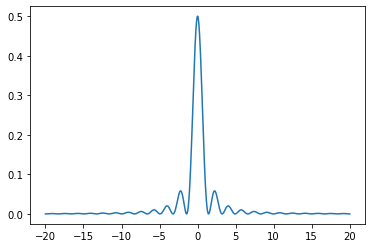

In [10]:
d, step = np.linspace(-20, 20, 1000, retstep=True)
plt.plot(d, lineshape(d, 600e-3))

62.89474781961545

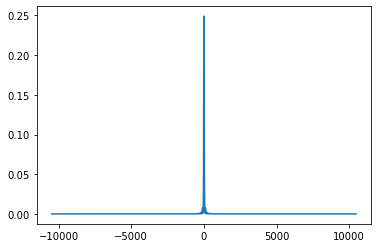

In [11]:
# scaling lineshape
scaling_param = (np.pi / 6e-3)
l_s = lineshape(d, 20)
plt.plot(d * scaling_param, l_s)
widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
d[int(np.rint(widths[3][0]))]*scaling_param-d[int(np.rint(widths[2][0]))]*scaling_param

The slope ($k_p(\delta, t)$) is calculated using a simple finite differential scheme from the lineshape. More sophisticated methods could also be used.

-0.022759522384179987

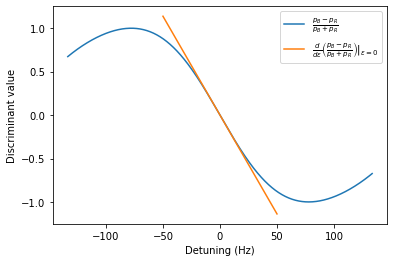

In [12]:
def slope(lineshape_func, delta, t, dlims=(-2, 2), acc=1000):
    assert(delta > dlims[0] and delta < dlims[1]), "Derivative not defined outside range!"
    ds, step = np.linspace(dlims[0], dlims[1], acc, retstep=True)
    lineshape = lineshape_func(ds, t)
    d_ls = np.diff(lineshape) / step
    nearest = np.argmin(np.abs(ds-delta))
    return d_ls[nearest]

def FWHM(lineshape, delta):
    width = peak_widths(lineshape, [np.argmax(lineshape)], rel_height=0.5)
    out = delta[int(np.rint(width[3][0]))] - delta[int(np.rint(width[2][0]))]
    return out

def k_p(lineshape_func, delta, t, n=1000):
    fwhm = FWHM(lineshape_func(delta, t), delta)
    d_R = np.linspace(start=delta[0], stop=delta[-1] - fwhm, num=n)
    d_B = d_R + fwhm
    d = d_R + fwhm / 2.
    p_R = lineshape_func(d_R, t)
    p_B = lineshape_func(d_B, t)
    #k = p_B - p_R
    k = np.divide(p_B - p_R, p_B + p_R)
    d_k = np.diff(k) / (d[1] - d[0])
    origin = d_k[np.argmin(np.abs(d))]
    return origin, k, d

d, step = np.linspace(-200, 200, 10000, retstep=True)
kp, d_k, d = k_p(lineshape, d, 6e-3)
plt.plot(d, d_k, label=r"$\frac{p_B - p_R}{p_B + p_R}$")
d_kp = np.linspace(-50, 50, 100)
tangent = d_kp * kp
plt.plot(d_kp, tangent, label=r"$\frac{d}{d \epsilon}\left(\frac{p_B - p_R}{p_B + p_R}\right)|_{\epsilon=0}$")
plt.legend()
plt.xlabel("Detuning (Hz)")
plt.ylabel("Discriminant value")
kp

In [21]:
def get_both_ps(d, lineshape_func, t, laser_offset=None):
    l_s =lineshape_func(d, t) # generate lineshape data
    widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5) #get FWMH data
    x_R = d[int(np.rint(widths[2][0]))]
    x_B = d[int(np.rint(widths[3][0]))]
    p_R = p_B = widths[1][0]
    if laser_offset is not None:
        x_R += laser_offset
        x_B += laser_offset
        p_R = lineshape_func(x_R, t)
        p_B = lineshape_func(x_B, t)
    return {'x_R': x_R,
            'x_B': x_B,
            'p_R': p_R,
            'p_B': p_B}

Visualising the result of laser offset on the measured probabilities $p_R$ and $p_B$. Scipy ``peak_widths`` used here to calculate FWHM.

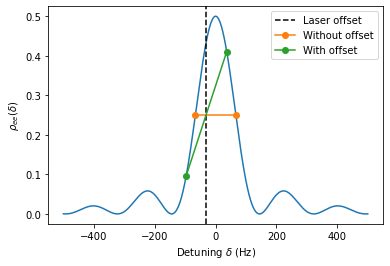

In [22]:
d, step = np.linspace(-500, 500, 1000, retstep=True)
l_s = lineshape(d, 6e-3)
widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
without_offset = get_both_ps(d, lineshape, 6e-3)
laser_offset = -30
with_offset = get_both_ps(d, lineshape, 6e-3, laser_offset=laser_offset)
plt.plot(d, l_s)
plt.axvline(laser_offset, color='k', linestyle='--', label='Laser offset')
plt.plot([without_offset['x_R'], without_offset['x_B']],[without_offset['p_R'], without_offset['p_B']], marker='o', label='Without offset')
plt.plot([with_offset['x_R'], with_offset['x_B']],[with_offset['p_R'], with_offset['p_B']], marker='o', label='With offset')
plt.xlabel(r"Detuning $\delta$ (Hz)")
plt.ylabel(r"$\rho_{ee}(\delta)$")
plt.legend()

In [24]:
T_s = 5 #s
n_m = 100 #number of measurements per cycle
d, step = np.linspace(-500, 500, 1000, retstep=True)
l_s = lineshape(d, 6e-3)
def sampling_cycle(f0, T_s, n_m, theoretical_delta, tau_pi=6e-3, laser_drift=20e-6):
    time_step = T_s / n_m
    if laser_drift == 0.:
        detunings = np.ones(n_m) * f0 + theoretical_delta
    else:
        #print(time_step)
        detunings = np.arange(start=f0, stop=f0 + n_m * laser_drift * time_step, step = laser_drift * time_step) + theoretical_delta
    jump_probabilities = lineshape(detunings, tau_pi) # quantum jump p from theory
    measured_results = binom.rvs(n=1, p=jump_probabilities) # draws from binomial
    p_X = np.sum(measured_results) / n_m
    return p_X, detunings[-1] - theoretical_delta
sampling_cycle(0, T_s, 100, FWHM(l_s, d)/2, 6e-3)

(0.27, 9.900000000584441e-05)

Text(0, 0.5, 'Allan deviation $\\sigma_y(\\tau)$')

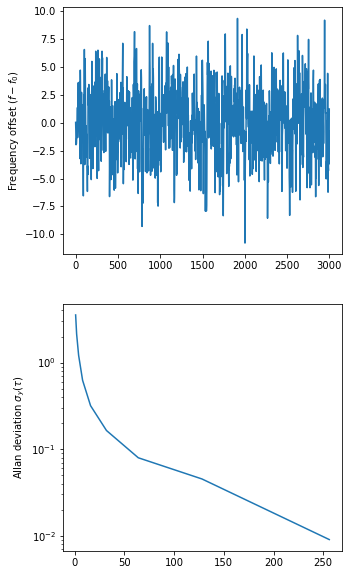

In [27]:
# main simulation loop
n_s = 100 # number of samples
tau_pi = 6e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c
initial_offset = 0 # Hz
state_preparation = False
max_tau = 3000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
t = np.arange(start=T_c, stop=max_tau, step=n_c*T_s)
etas = np.zeros(len(t))
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(lineshape, d, tau_pi)
fwhm = FWHM(lineshape(d, tau_pi), d)
p_X = 0.5 if state_preparation else 0.25
g = -2 * p_X / kp # gain
f = initial_offset
for i in range(0, len(t)):
    tau = t[i]
    #print(f)
    p_B, f = sampling_cycle(f, T_s, n_m, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    p_R, f = sampling_cycle(f, T_s, n_m, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    #print(f"p_R: {p_R}, p_B: {p_B}, without gain: {(p_B - p_R) / (p_B + p_R)}")
    etas[i] = f
    E = g * (p_B - p_R) / (p_B + p_R)
    #print(f"Current f offset: {f}; error signal: {E}")
    f = f + E

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
ax[0].plot(t, etas)
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
(taus, adevs, errors, ns) = allantools.adev(etas)
ax[1].plot(taus, adevs)
ax[1].set_yscale('log')
ax[1].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")

<f> = 0.0022123699913466637, laser drift during one cycle = 0.048


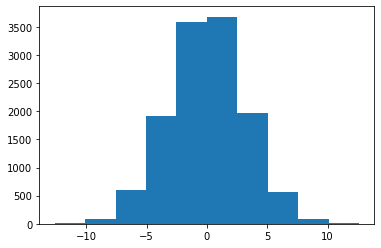

In [132]:
plt.hist(etas)
print(f"<f> = {np.mean(etas)}, laser drift during one cycle = {T_s * laser_drift * n_c}")

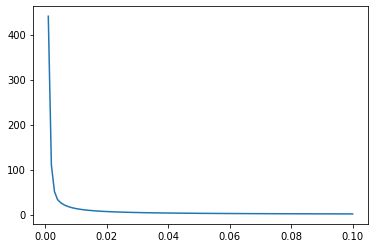

In [118]:
tau_pi = np.linspace(1e-3, 100e-3, 100)
gs = np.zeros(100)
for i in range(len(tau_pi)):
    kp, _, _ = k_p(lineshape, d, tau_pi[i])
    fwhm = FWHM(lineshape(d, tau_pi[i]), d)
    p_X = 0.5 if state_preparation else 0.25
    g = -2 * p_X / kp # gain
    gs[i] = g

plt.plot(tau_pi, gs)

### Laser noise simulation
Cauchy distribution (how to translate into $\Omega_R$-space?), looks ok.

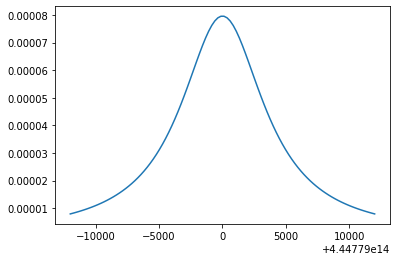

In [282]:
laser_lw = 4e3 #Hz, guess
eta0 = 444.779e12 # transition center
l = np.linspace(eta0 - 3*laser_lw, eta0 + 3*laser_lw, 100)
plt.plot(l, cauchy.pdf(l, loc=eta0, scale=laser_lw))

### Sampling function

(0.02, 252.252351252252)